
# Lab 1 Image Classification with CNNs

Created by Tomas Nordström, Umeå University

Adapted by Jacob Farnsworth for HT 2025 Programmering för tekniska tillämpningar, NTI Gymnasiet Karlstad

## **Write your name here.**

## Background: Image Classification

Here's an experiment: Look at the picture below. What digit do you see?

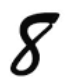

Chances are, you can tell me that this is a picture of the number eight. And chances are, you can tell me this pretty quickly, without having to think about it too hard. So you might even say that classifying an image is *easy*.

But what if I asked you to explain *how* you know that this is a picture of the number eight? Imagine trying to teach someone to recognize the number eight, and you have to explain your thought process.

Explaining *how* you know probably isn't as easy. You might give a description such as:

*   Two circles squeezed together.
*   Two teardrop shapes stacked on top of each other.
*   Infinity symbol, but upright instead of sideways.
*   ... or some other explanation entirely.

However, these explanations also beg some questions: how would you recognize a circle? How would you recognize a teardrop shape? What is "up" or "sideways"?

Furthermore, an eight is either printed or written on paper, so you'd also need to explain what *printed* means, or what a *pen stroke* looks like. Black and line-like? But what if you use blue ink, instead of black?

It turns out that classifying an image is actually rather difficult! Your brain does a lot of subconscious processing of details and features that you aren't even aware of.

Consider this, and the fact that a typical image consists of multiple color channels, and hundreds of thousands, even millions of pixels. This is partly why for a long time, image classification was a very difficult task for traditional (logic-based) programming. But with the advancement of neural networks, especially *convolutional neural networks*, we can create models that can classify images with a high degree of accuracy.

## Convolutional Neural Networks (CNNs)

*Convolutional neural networks* are composed of *convolutional layers*, which can learn features in images. A model comprised of several convolutional layers together is able to learn *spatial hierarchies* of features in images.

By *spatial hierarchy of features*, we mean the following: Earlier layers can learn to recognize "simpler" features, such as brush strokes. Later layers take information from the earlier layers, and learn to recognize more complex features, for example a circle-shaped brush stroke. The final layers can recognize arrangements of these more complex features, for example two circle-shaped brush strokes stacked together.

Of course, this is a simplification, but this is roughly how a convolutional neural network works: the model learns a spatial hierarchy of features, starting with the simplest features, and ending with a classification.

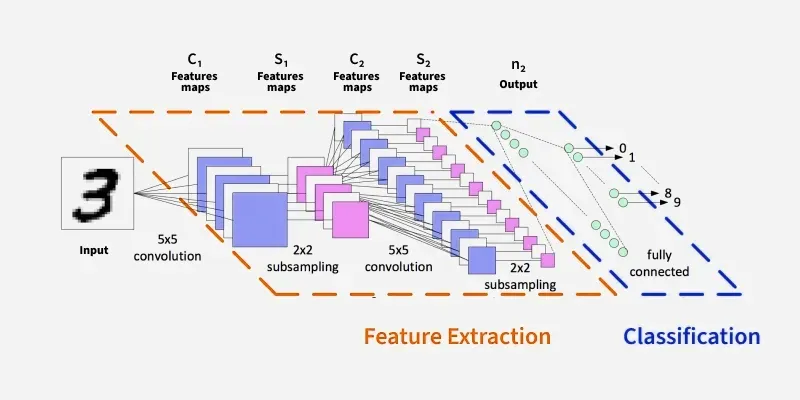

The above diagram shows the typical architecture of a convolutional neural network. CNNs are often built in two "stages": the first performs feature extraction, while the second performs the final classification.

**Feature extraction stage**

*    The *convolutional layers* (c1, c2) scan over the image using a *kernel* and learn to recognize features. You can think of the kernel as a smaller area within the image that the layer "focuses" on. Each convolutional layer produces a *feature map*. This type of layer is known as Conv2D in Tensorflow.
*    The *subsampling layers* (s1, s2) are used to downsample the feature maps, that is, reduce their size while retaining important information, and filtering away unimportant information. There are several different types of subsampling layers. In Tensorflow the most commonly used are MaxPool2D and AveragePooling2D.

**Classification stage**

In this stage, the output from the feature extraction (which is multi-dimensional) is *flattened* to one dimension.

After flattening, the feature extraction output is fed through one or more fully-connected layers (called Dense layers in Tensorflow). Finally, the last output is a length-N vector, the classfication.



**Output**

With any classification task, a model's output is usually a probability distribution over a length-N vector, where N is the number of categories. Each entry in the vector represents a probability for a certain category.

For example, for a model trained to recognize rock, paper or scissors, the categories might be coded as follows:

- (0  0  1) Rock
- (0  1  0) Paper
- (1  0  0) Scissors

This scheme of encoding is called *one-hot encoding*.

Say the model outputs (0.88  0  0.1). This would represent a prediction of *scissors*.

## Lab introduction

In this lab, you will use the popular machine-learning framework Tensorflow to create and train a CNN for image classification.

We will be working with the Fashion-MNIST dataset. This dataset consists of a training set of 60,000 images, and a test set of 10,000 images. The images in Fashion-MNIST are grayscale 28x28. The dataset has 10 different categories of clothing images.

You can read more about Fashion-MNIST [here](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

## Initialize Python environment

The code below imports some needed libraries, and configures Tensorflow to use the GPU. Make sure that you're using a GPU runtime in Colab: top right corner, click the arrow next to "connect", and then click "change runtime type".

In [ ]:
#### Set up tests to know if we are running Colab or Kaggle
import sys
import os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Import TF/Keras libraries
os.environ["KERAS_BACKEND"] = "tensorflow" # Can be "tensorflow" "jax" "pytorch"

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

2025-03-24 23:09:53.856382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742854193.897269    4100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742854193.909403    4100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 23:09:54.018616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Keras version: 3.7.0


In [ ]:
# Import needed libraries
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Test for GPU and determine what GPU we have
import platform
import subprocess
gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 12.5.1
(b'GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-56d64c0c-e161-9720-5e6d-9848f27424d1)\n', b'')
Compute capability: (8, 6)
Turning on mixed_float16


2025-03-24 23:09:57.215315: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1742854197.216567    4100 gpu_device.cc:2022] Created device /device:GPU:0 with 22224 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1742854197.221967    4100 gpu_device.cc:2022] Created device /device:GPU:0 with 22224 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## Set up the needed data sets

### Get hold of a data-set

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) :
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) :
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) :
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes!

### Adjust the data to work better as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [ ]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

### Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: T-shirt/top


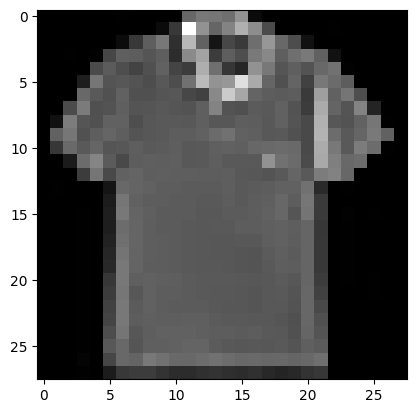

Label: Pullover


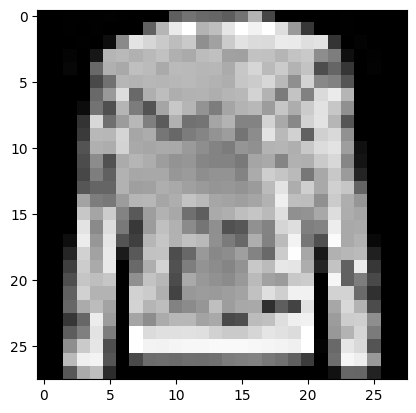

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=-1))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

### Questions

Answer the following questions. You may search online, but please *cite your sources* to support your answers.

1.   In this lab, we are using an *80-20 train-test split*. What is a train-test split, and why is it important to use when training a machine-learning model?
2.   What does it mean to normalize (sometimes called standardize) input data, especially images? Why is it important?
3.   What is *one-hot encoding*? Where and why is this encoding scheme used in ML models?



### Your Answers

Write your answers to the understanding questions here.


1.   
2.   
3.

## Define a convolutional network model

### Define the model using Keras

Note that this is a *very* small model just to have a starting point. A good model is expected to have 5-50 times as many parameters!

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = keras.models.Sequential([

# Define input layer with shape
keras.Input(shape=input_shape, name='InputLayer'),

# Add a convolution layer
keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),

# Flatten the input. This prepares the vector for fully connected layers.
keras.layers.Flatten(),

# Add a hidden Dense layer
keras.layers.Dense(units=16, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
keras.layers.Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)


I0000 00:00:1742854198.028902    4100 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22224 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       200,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,050 (785.35 KB)

 Trainable params: 201,050 (785.35 KB)

 Non-trainable params: 0 (0.00 B)

## Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

## Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15


I0000 00:00:1742854199.344083    4215 service.cc:148] XLA service 0x72e020009b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742854199.344190    4215 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-24 23:09:59.365515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742854199.464350    4215 cuda_dnn.cc:529] Loaded cuDNN version 90501


 162/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - categorical_accuracy: 0.5657 - loss: 1.2272

I0000 00:00:1742854200.850711    4215 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.7682 - loss: 0.6564 - val_categorical_accuracy: 0.8734 - val_loss: 0.3623
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.8845 - loss: 0.3322 - val_categorical_accuracy: 0.8799 - val_loss: 0.3299
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.8965 - loss: 0.2860 - val_categorical_accuracy: 0.8898 - val_loss: 0.3100
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.9096 - loss: 0.2495 - val_categorical_accuracy: 0.8926 - val_loss: 0.3049
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.9217 - loss: 0.2210 - val_categorical_accuracy: 0.8908 - val_loss: 0.3191
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.9269 - loss: 0.2009 - val_categorical_accuracy: 0.9030 - val_loss: 0.2834
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.9340 - 

## Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

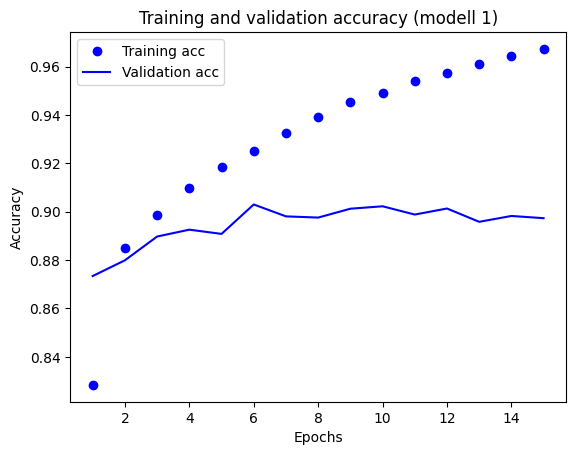

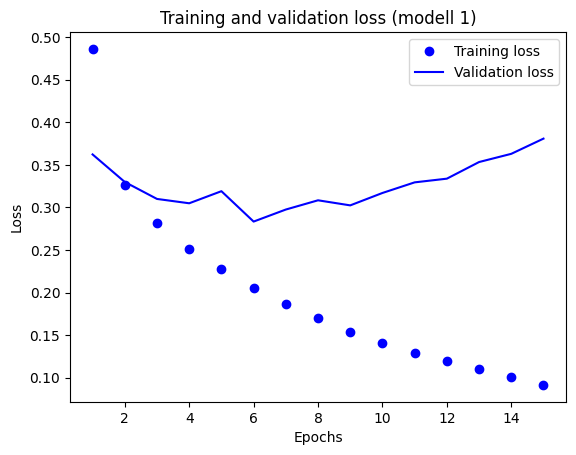

In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

## Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8979 - loss: 0.3834
Test accuracy: 0.896


## Övning Del 1a
### Frågor att besvara:
* Hur många parametrar har din modell?
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad? Hur vet du? Vad i träningskurvorna kan avgöra det?
* Hur många epochs skulle ha varit lämpligt att använda?

### STUDENTSVAR (FRÅGOR):
*   

## Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då?
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där valideringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

### STUDENTSVAR (KOD):

In [ ]:
# Kod för din bästa modell och dess träning och utvärdering

### Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.

### STUDENTSVAR (ANALYS):

"sammanfattande analys av dina experiment hittills"

## Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [Se Geron s. 162 för "Early Stopping"]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


### STUDENTSVAR (KOD)

In [ ]:
# Kod där du inför avbruten träning

### Analys
Vid vilken Epoch stannar nu träningen? Ändras nu modellens testnoggrannhet då den inte övertränar?

### STUDENTSVAR (ANALYS):
"träningsbeteende"

## Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering.

Se Tensorflows dokumentation om:
* [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
* [Batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [Se Geron s. 367 för "Batch Normalization"; s 392.. "Avoiding Overfitting Through Regularization"]

### STUDENTSVAR (KOD):

In [ ]:
# Kod där du inför regularisering

### Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen?

### STUDENTSVAR (ANALYS):
"jämför dina modeller"

## Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [Se Geron s. 351.., för  "Lerning Rate, Batch Size, and Other Hyperparameters";  s. 379..  "Faster optimizers",]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort värde kan ge instabil träning.

## (VG) Automated hyperparameter tuning

There are many different hyperparameters and options to adjust, and it can be quite a lot of work trying to find the optimal configuration for a model.

In this part, we will test a *hyperparameter optimizer* called Keras Tuner. Keras Tuner can be used to do an automated search and find an optimal set of hyperparameters.

Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab or kaggle)
if (IS_COLAB or IS_KAGGLE):
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

Keras Tuner version: 1.4.7


### Exempelmodell (du ska sedan göra med din egen modell!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5,
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):
  model = keras.Sequential([
    keras.Input(shape=(28,28,1)),
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

### Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 2 och instrumentera den för att optimeras med Keras Tuner.

### STUDENTSVAR (KOD):

In [ ]:
# Kompletera denna kod med din modell
def build_model_MyModel(hp):
  model = keras.models.Sequential([
    keras.Input(shape=(28,28,1)),
    # First Convolutional Layer'
    ##### YOUR CODE HERE! #####

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

### Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization.

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_2Conv1Dense, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

/home/tono/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Help it takes so much time!
Yes, doing a parameter search takes time! Using a T4 this search takes 50 minutes (while a RTX 3090 takes 15 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels,
             epochs=noepochauto,
             validation_data=(val_images, val_labels),
             callbacks=[es])

Trial 20 Complete [00h 01m 19s]
val_accuracy: 0.9197499752044678

Best val_accuracy So Far: 0.9222500026226044
Total elapsed time: 00h 15m 48s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       conv_1_filter = 128
       conv_1_kernel =   3
       conv_2_filter =  32
       conv_2_kernel =   3
       dense_1_units = 256
       learning_rate = 0.001
          batch_size =  96


/home/tono/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,647,146 (6.28 MB)

 Trainable params: 1,646,890 (6.28 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9182 - loss: 0.2373
Test accuracy: 0.919


### Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trial on a seperate row from best to worst
  for ix in range(0,explorenbest):
    # evaluate this trial
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trial's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trial
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   dense_1_units   learning_rate      batch_size 

          0.919             128               3              32               3             256           0.001              96 
          0.916             256               3             256               3             256           0.001              32 


2025-03-24 23:26:28.566758: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 4 bytes spill stores, 4 bytes spill loads



          0.919             224               3             160               5             128           0.001             160 
          0.916             224               3              32               3              32           0.001             224 
          0.917              96               3             192               3             224           0.001             256 


Notice that the model with the best validation accuracy does not necessarily give the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation.

### With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9553 - loss: 0.1214 - val_accuracy: 0.9197 - val_loss: 0.2478
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9675 - loss: 0.0872 - val_accuracy: 0.9148 - val_loss: 0.2690
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9778 - loss: 0.0608 - val_accuracy: 0.9169 - val_loss: 0.3067
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9167 - loss: 0.2706
Test accuracy: 0.916


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,940,928 (18.85 MB)

 Trainable params: 1,646,890 (6.28 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 3,293,782 (12.56 MB)

### Analys
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden du fått fram i del 1 och del 2?
* Vilka prestanda fick du för de olika fallen?
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsefulla?
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)?
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?

### STUDENTSVAR (ANALYS):
"en komplett analys"

# AI Deklaration
Användning av Al-verktyg är tillåtet i begränsad utsträckning. Du får inte klistra in uppgifter eller delar av uppgifter, men du får använda AI för att förtydliga nya ord och begrepp eller ge exempel.

Här på slutet ska du ange allmänt vilka AI-verktyg som använts, hur du använt dem, och hur användbara dessa verktyg är. Om du inte använt AI-stöd så skriv bara att "AI-verktyg har ej använts".

### STUDENTSVAR (AI-användning):